<h2 align=center>Tumor Diagnosis: Feature Selection & Classification</h2>

### About the Dataset:

The [Breast Cancer Diagnostic data](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) is available on the UCI Machine Learning Repository. This database is also available through the [UW CS ftp server](http://ftp.cs.wisc.edu/math-prog/cpo-dataset/machine-learn/cancer/WDBC/).

Data Set Information:

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. A few of the images can be found at [Web Link]

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes.

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC/


Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

### 1. Loading Libraries and Data

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('data_cancer.csv')

### Separate Target from Features

In [3]:
y = data.diagnosis                           
drop_cols = ['Unnamed: 32','id','diagnosis']
x = data.drop(drop_cols,axis = 1 )
x.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())   

### 2. Dropping Correlated Columns from Feature Matrix aka Feature Prunning
***

### 2.1 Observing all Pair-wise Correlations

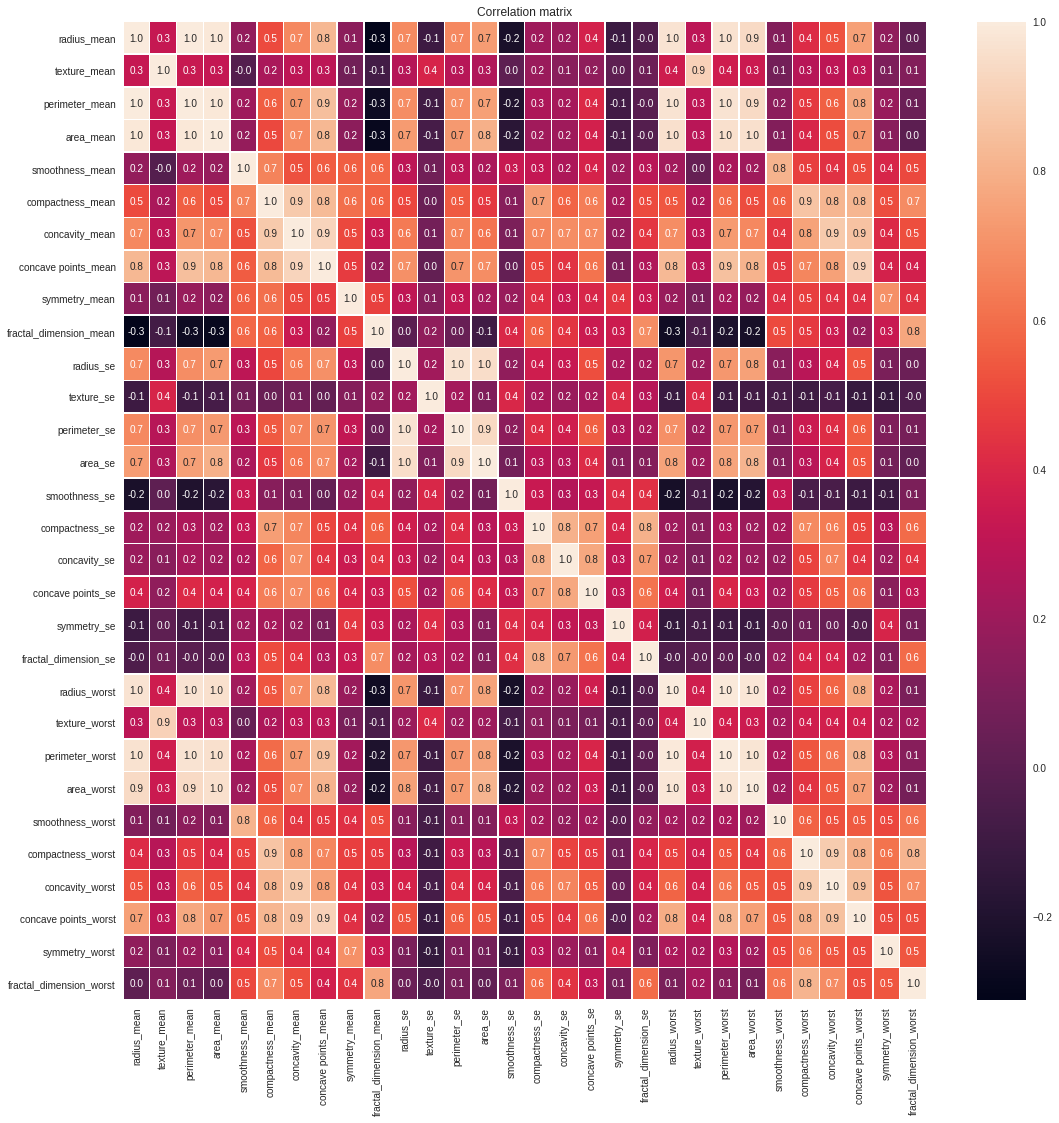

In [5]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation matrix');

In [9]:
xcor = x.corr()
correlated_features = set()

for i in range(len(xcor.columns)):
    for j in range(i):
        if abs(xcor.iloc[i, j]) >= 0.9:
            colname = xcor.columns[i]
            correlated_features.add(colname)

correlated_features 

{'area_mean',
 'area_se',
 'area_worst',
 'concave points_mean',
 'concave points_worst',
 'perimeter_mean',
 'perimeter_se',
 'perimeter_worst',
 'radius_worst',
 'texture_worst'}

### 2.2. Dropping correlated features

So, we're removing bright clusters/squares from the heatmap

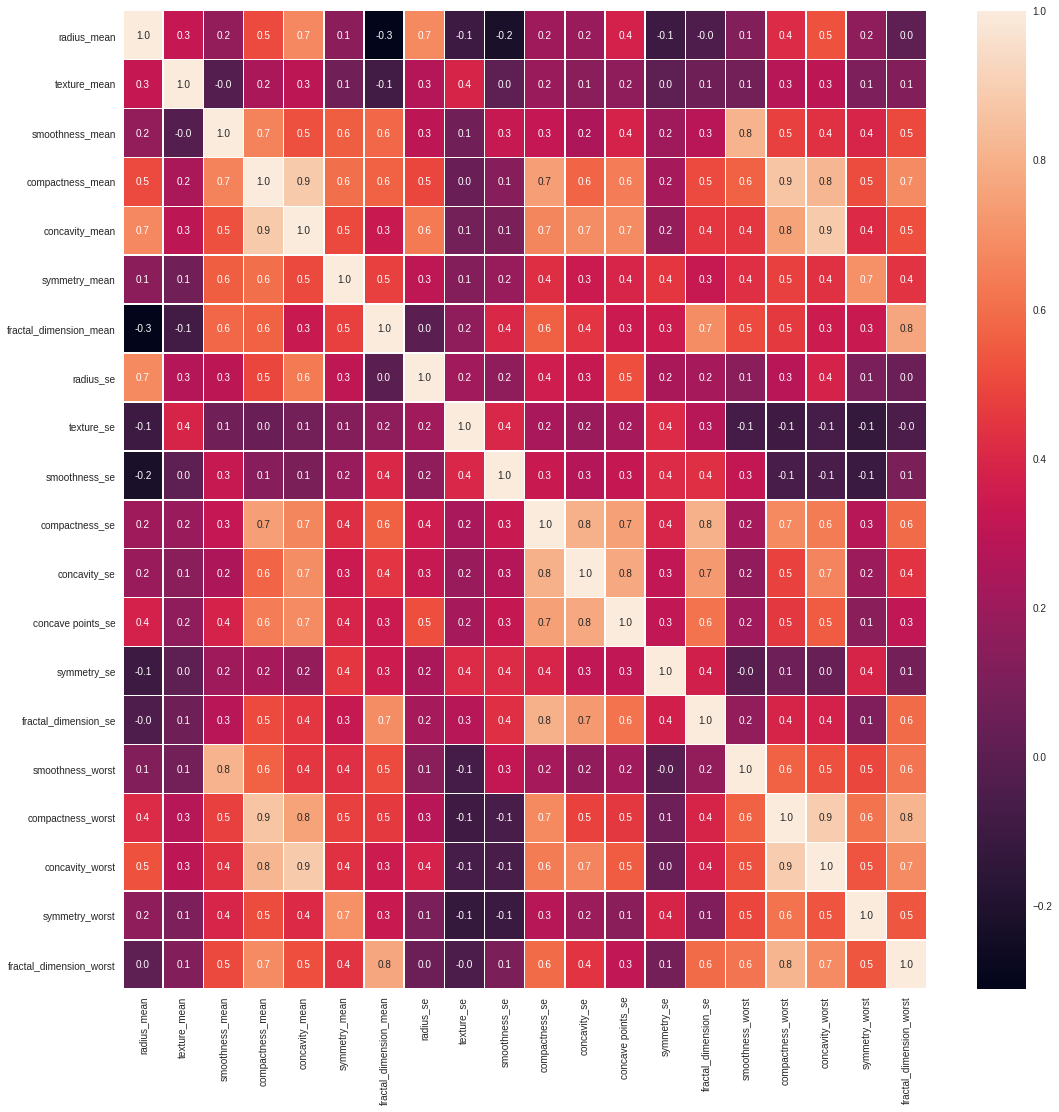

In [10]:
# corr_cols = ['perimeter_mean','radius_mean','compactness_mean',
#               'concave points_mean','radius_se','perimeter_se',
#               'radius_worst','perimeter_worst','compactness_worst',
#               'concave points_worst','compactness_se','concave points_se',
#               'texture_worst','area_worst']
df = x.drop(columns=correlated_features)
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

### 3. Classification using XGBoost (minimal feature selection)

In [11]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

clf_1 = xgb.XGBClassifier(random_state=42)
clf_1.fit(x_train, y_train)
print(f'Accuracy: {accuracy_score(y_test, clf_1.predict(x_test))}')

Accuracy: 0.9649122807017544


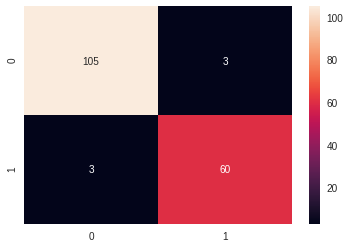

In [13]:
cm_1 = confusion_matrix(y_test, clf_1.predict(x_test))
sns.heatmap(cm_1, annot=True, fmt='d');

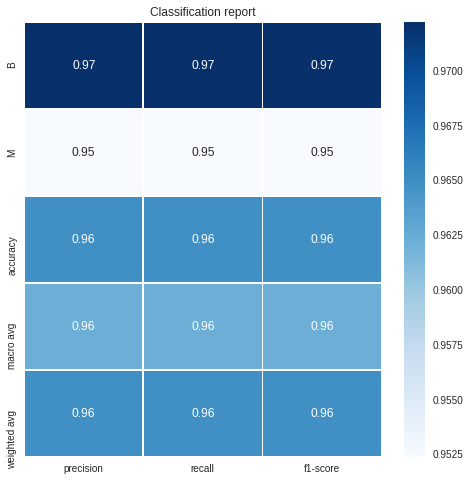

In [24]:
clf_report_1 = classification_report(y_test, clf_1.predict(x_test),
                                   output_dict=True)

# .iloc[:-1, :] to exclude support
plt.figure(figsize=(8, 8))
sns.heatmap(pd.DataFrame(clf_report_1).iloc[:-1, :].T, annot=True, cmap="Blues", linewidths=.5)
plt.title('Classification report');

### 4. Univariate Feature Selection and XGBoost

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [26]:
select_k_features = SelectKBest(chi2, k=10).fit(x_train, y_train)

print('Score List: \n', select_k_features.scores_)
print('Features: \n', x_train.columns)

Score List: 
 [1.77946492e+02 6.06916433e+01 1.00015175e-01 3.41839493e+00
 1.30547650e+01 1.95982847e-01 3.42575072e-04 2.45882967e+01
 4.07131026e-02 1.32470372e-03 3.74071521e-01 6.92896719e-01
 2.01587194e-01 1.39557806e-03 2.65927071e-03 2.63226314e-01
 1.19077581e+01 2.58858117e+01 1.00635138e+00 1.23087347e-01]
Features: 
 Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'smoothness_worst', 'compactness_worst',
       'concavity_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


Accuracy: 0.9707602339181286


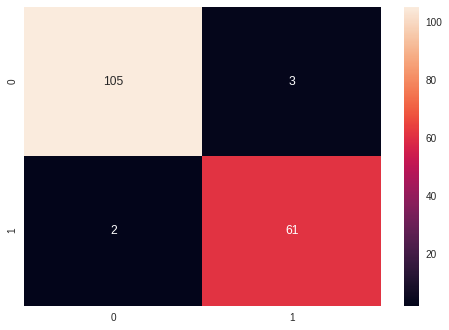

In [27]:
x_train_2 = select_k_features.transform(x_train)
x_test_2 = select_k_features.transform(x_test)

clf_2 = xgb.XGBClassifier(random_state=42).fit(x_train_2, y_train)
print(f'Accuracy: {accuracy_score(y_test, clf_2.predict(x_test_2))}')
cm_2 = confusion_matrix(y_test, clf_2.predict(x_test_2))
sns.heatmap(cm_2, annot=True, fmt='d');

### 5. Recursive Feature Elimination with Cross-Validation

In [28]:
from sklearn.feature_selection import RFECV

clf_3 = xgb.XGBClassifier(random_state=42)
rfecv = RFECV(estimator=clf_3, step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfecv.fit(x_train, y_train)

print('OPtimal number of features: ', rfecv.n_features_)
print('Best features: ', x_train.columns[rfecv.support_])

OPtimal number of features:  10
Best features:  Index(['radius_mean', 'texture_mean', 'concavity_mean', 'radius_se',
       'smoothness_se', 'symmetry_se', 'smoothness_worst', 'compactness_worst',
       'concavity_worst', 'symmetry_worst'],
      dtype='object')


In [29]:
accuracy_score(y_test, rfecv.predict(x_test))

0.9707602339181286

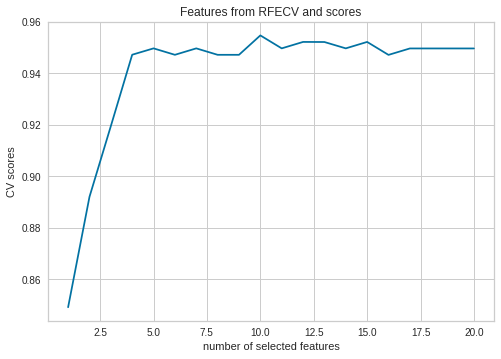

In [35]:
num_features = [i for i in range(1, len(rfecv.grid_scores_)+1)]
cv_scores = rfecv.grid_scores_
ax = sns.lineplot(x=num_features, y=cv_scores)
ax.set(xlabel = 'number of selected features', ylabel='CV scores')
plt.title('Features from RFECV and scores');

### 6. Feature Extraction using Principal Component Analysis

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# minmax scaling
x_train_norm = (x_train - x_train.min())/(x_train.max() - x_train.min())
x_test_norm = (x_test - x_test.min())/(x_test.max()- x_test.min())

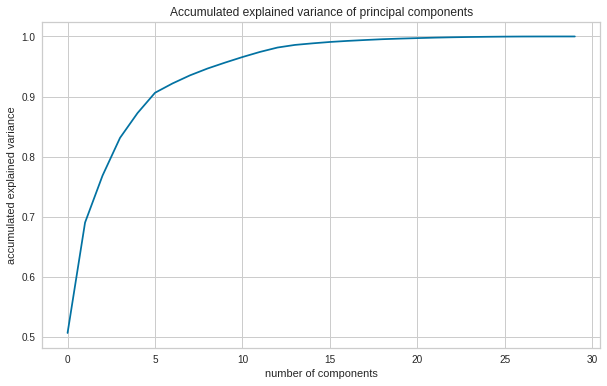

In [39]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train_norm)

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_))
ax.set(xlabel = 'number of components', ylabel='accumulated explained variance')
plt.title('Accumulated explained variance of principal components');

### 7. RFC

In [41]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(x_train, y_train)
print(f'Accuracy: {accuracy_score(y_test, clf_rf.predict(x_test))}')

Accuracy: 0.9707602339181286
